In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf

TICKER = "QQQ"
START = "2024-01-01"
END = "2024-12-31"

WICK_FACTOR = 2.0
VOLUME_MULTIPLIER = 1.5
VOLUME_WINDOW = 20
TREND_LOOKBACK = 50
LOOKBACK_SR = 20
MIN_BODY_FRAC = 0.001
RR_RATIO = 10.0
SUPPORT_PROX = 0.01

def load_data_yf(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval="1h", auto_adjust=False)
    if df is None or df.empty:
        raise ValueError("No data downloaded. Check ticker/dates or network.")
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    df = df.reset_index()
    df.columns = [str(c).strip().title() for c in df.columns]
    if "Adj Close" in df.columns and "Close" not in df.columns:
        df.rename(columns={"Adj Close": "Close"}, inplace=True)
    if "Date" not in df.columns:
        if "Datetime" in df.columns:
            df.rename(columns={"Datetime": "Date"}, inplace=True)
    required = ["Date", "Open", "High", "Low", "Close", "Volume"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    df = df.loc[:, required].copy()
    df = df.sort_values("Date").reset_index(drop=True)
    return df

def identify_trend(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["EMA50"] = df["Close"].ewm(span=TREND_LOOKBACK, adjust=False).mean()
    df["Trend"] = np.where(df["Close"] < df["EMA50"], "Down", "Up")
    return df

def identify_support_resistance(df: pd.DataFrame, lookback: int = LOOKBACK_SR) -> pd.DataFrame:
    df = df.copy()
    is_swing_low = (df["Low"].shift(1) > df["Low"]) & (df["Low"].shift(-1) > df["Low"])
    is_swing_high = (df["High"].shift(1) < df["High"]) & (df["High"].shift(-1) < df["High"])
    df["SwingLow"] = np.where(is_swing_low, df["Low"], np.nan)
    df["SwingHigh"] = np.where(is_swing_high, df["High"], np.nan)
    df["Support"] = df["SwingLow"].rolling(window=lookback, min_periods=1).min()
    return df

def detect_bullish_rb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    body = (df["Close"] - df["Open"]).abs()
    is_bull = df["Close"] > df["Open"]
    lower_wick = df["Open"] - df["Low"]
    upper_wick = df["High"] - df["Close"]
    cond = (
        is_bull &
        (lower_wick > body * WICK_FACTOR) &
        (upper_wick < body) &
        (body > df["Close"] * MIN_BODY_FRAC)
    )
    df["Bullish_RB"] = cond.astype(int)
    return df

def detect_bv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    avg_vol = df["Volume"].rolling(window=VOLUME_WINDOW, min_periods=1).mean()
    cond = (df["Close"] > df["Open"]) & (df["Volume"] > avg_vol * VOLUME_MULTIPLIER)
    df["BV"] = cond.astype(int)
    return df

def detect_rsrb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["RSRB"] = 0
    last_rb_low = np.nan
    for i in range(len(df)):
        if df.at[i, "Bullish_RB"] == 1:
            if not np.isnan(last_rb_low):
                if abs(df.at[i, "Low"] - last_rb_low) / max(df.at[i, "Close"], 1e-12) < 0.01:
                    df.at[i, "RSRB"] = 1
            last_rb_low = df.at[i, "Low"]
    return df

def detect_rbm(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["RBM"] = 0
    for i in range(1, len(df)):
        if df.at[i-1, "Bullish_RB"] == 1 and df.at[i, "Close"] > df.at[i-1, "Low"]:
            df.at[i, "RBM"] = 1
    return df

def find_fta(df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    df = df.copy()
    swing = df["SwingHigh"].fillna(method="ffill")
    rev = swing[::-1]
    fut_max = rev.rolling(window=window, min_periods=1).max()[::-1]
    df["FTA"] = fut_max.shift(-1)
    return df

def build_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = identify_trend(df)
    df = identify_support_resistance(df)
    df = detect_bullish_rb(df)
    df = detect_bv(df)
    df = detect_rsrb(df)
    df = detect_rbm(df)
    df = find_fta(df)
    return df

def simulate_trades(df: pd.DataFrame) -> pd.DataFrame:
    records = []
    for i in range(len(df)):
        row = df.iloc[i]
        support = row.get("Support")
        if (
            row.get("Trend", "") == "Down"
            and pd.notna(support)
            and row["Low"] <= support * (1 + SUPPORT_PROX)
            and ((int(row.get("BV", 0)) == 1) or (int(row.get("Bullish_RB", 0)) == 1) or (int(row.get("RSRB", 0)) == 1) or (int(row.get("RBM", 0)) == 1))
        ):
            entry = float(row["Close"])
            stop = float(row["Low"]) * 0.99
            risk = max(entry - stop, 1e-8)
            target = entry + RR_RATIO * risk
            fta = row.get("FTA")
            if pd.notna(fta):
                try:
                    target = min(target, float(fta))
                except Exception:
                    pass
            outcome = None
            exit_price = None
            exit_date = None
            for j in range(i + 1, len(df)):
                h = float(df.at[j, "High"])
                l = float(df.at[j, "Low"])
                d = df.at[j, "Date"]
                if l <= stop:
                    outcome = -1.0
                    exit_price = stop
                    exit_date = d
                    break
                if h >= target:
                    outcome = (target - entry) / risk
                    exit_price = target
                    exit_date = d
                    break
            if outcome is None:
                exit_price = float(df.iloc[-1]["Close"])
                exit_date = df.iloc[-1]["Date"]
                outcome = (exit_price - entry) / risk
            signal_name = "BV" if int(row.get("BV", 0)) == 1 else ("RB" if int(row.get("Bullish_RB", 0)) == 1 else ("RSRB" if int(row.get("RSRB", 0)) == 1 else "RBM"))
            records.append({
                "EntryDate": row["Date"],
                "ExitDate": exit_date,
                "Entry": entry,
                "Stop": stop,
                "Target": target,
                "Exit": exit_price,
                "R": outcome,
                "Signal": signal_name,
            })
    return pd.DataFrame(records)

def summarize_performance(trades: pd.DataFrame) -> pd.DataFrame:
    if trades is None or trades.empty:
        return pd.DataFrame({
            "Trades": [0], "Wins": [0], "WinRate": [0.0], "TotalR": [0.0], "AvgR": [0.0],
            "MaxDD_R": [0.0], "SharpeR": [0.0]
        })
    total_r = trades["R"].sum()
    wins = (trades["R"] > 0).sum()
    n = len(trades)
    winrate = wins / n
    avg_r = trades["R"].mean()
    eq = trades["R"].cumsum()
    peak = eq.cummax()
    dd = eq - peak
    maxdd = abs(dd.min()) if not dd.empty else 0.0
    r_std = trades["R"].std(ddof=1)
    sharpe = (avg_r / r_std * np.sqrt(n)) if r_std > 1e-9 else 0.0
    return pd.DataFrame({
        "Trades": [n],
        "Wins": [int(wins)],
        "WinRate": [round(winrate, 3)],
        "TotalR": [round(total_r, 3)],
        "AvgR": [round(avg_r, 3)],
        "MaxDD_R": [round(float(maxdd), 3)],
        "SharpeR": [round(float(sharpe), 3)],
    })

if __name__ == "__main__":
    df = load_data_yf(TICKER, START, END)
    df = build_signals(df)
    trades = simulate_trades(df)
    summary = summarize_performance(trades)
    pd.set_option("display.width", 180)
    pd.set_option("display.max_columns", None)
    print({
        "ticker": TICKER,
        "period": f"{START}..{END}",
        "RR": RR_RATIO,
        "wick_factor": WICK_FACTOR,
        "vol_mult": VOLUME_MULTIPLIER,
        "trend_ema": TREND_LOOKBACK,
        "support_lookback": LOOKBACK_SR,
    })
    print(trades.head(50))
    print(summary)



[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3737340748.py:99: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  swing = df["SwingHigh"].fillna(method="ffill")


{'ticker': 'QQQ', 'period': '2024-01-01..2024-12-31', 'RR': 10.0, 'wick_factor': 2.0, 'vol_mult': 1.5, 'trend_ema': 50, 'support_lookback': 20}
                   EntryDate                  ExitDate       Entry        Stop      Target        Exit         R Signal
0  2024-01-03 18:30:00+00:00 2024-01-08 14:30:00+00:00  400.179993  394.099187  400.440002  400.440002  0.042759     RB
1  2024-01-03 19:30:00+00:00 2024-01-08 14:30:00+00:00  398.779999  394.485301  400.440002  400.440002  0.386524    RBM
2  2024-01-05 14:30:00+00:00 2024-01-09 17:30:00+00:00  398.589996  392.198404  406.690002  406.690002  1.267291     BV
3  2024-02-01 14:30:00+00:00 2024-02-02 19:30:00+00:00  420.309998  413.661596  430.239990  430.239990  1.493591     BV
4  2024-02-13 14:30:00+00:00 2024-02-15 18:30:00+00:00  430.065002  422.017199  434.980011  434.980011  0.610727     BV
5  2024-02-13 15:30:00+00:00 2024-02-13 19:30:00+00:00  430.320007  425.373313  434.989990  425.373313 -1.000000     BV
6  2024-02-13 20

[*********************100%***********************]  1 of 1 completed


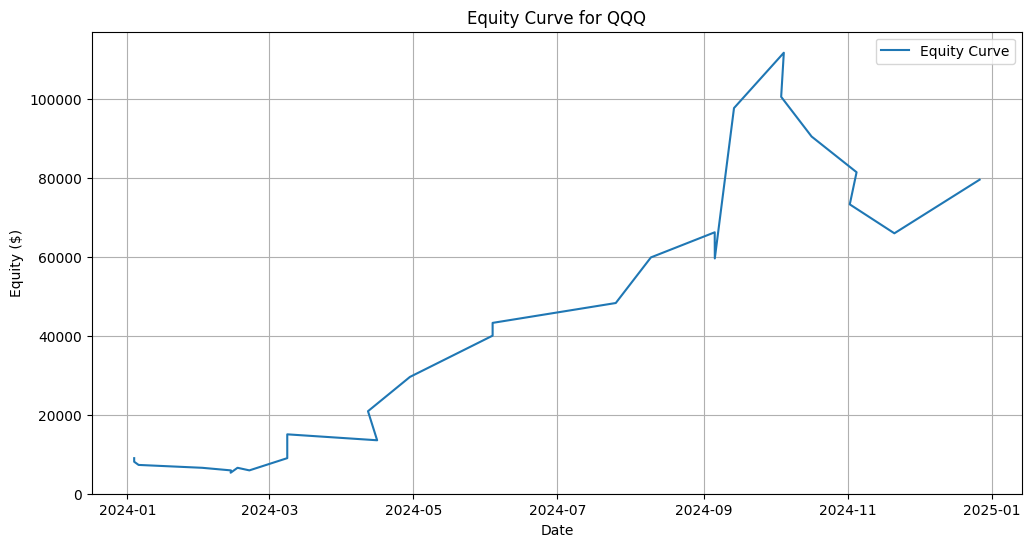

                   EntryDate                  ExitDate       Entry        Stop      Target        Exit         R Signal  PositionSize         Equity
0  2024-01-03 18:30:00+00:00 2024-01-03 20:30:00+00:00  400.179993  398.079987  400.440002  398.079987 -1.000000     RB    476.189092    9000.000000
1  2024-01-03 19:30:00+00:00 2024-01-03 20:30:00+00:00  398.779999  398.470001  400.440002  398.470001 -1.000000    RBM   2903.248671    8100.000000
2  2024-01-05 14:30:00+00:00 2024-01-05 17:30:00+00:00  398.589996  396.160004  406.690002  396.160004 -1.000000     BV    333.334338    7290.000000
3  2024-02-01 14:30:00+00:00 2024-02-01 15:30:00+00:00  420.309998  417.839996  430.239990  417.839996 -1.000000     BV    295.141555    6561.000000
4  2024-02-13 14:30:00+00:00 2024-02-13 19:30:00+00:00  430.065002  426.279999  434.980011  426.279999 -1.000000     BV    173.341972    5904.900000
5  2024-02-13 15:30:00+00:00 2024-02-13 16:30:00+00:00  430.320007  429.670013  434.989990  429.670013 -1.

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

TICKER = "QQQ"
START = "2024-01-01"
END = "2024-12-31"

WICK_FACTOR = 2.0
VOLUME_MULTIPLIER = 1.5
VOLUME_WINDOW = 20
TREND_LOOKBACK = 50
LOOKBACK_SR = 20
MIN_BODY_FRAC = 0.001
RR_RATIO = 10.0
SUPPORT_PROX = 0.01
INITIAL_CAPITAL = 10000
RISK_PER_TRADE = 0.1

def load_data_yf(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval="1h", auto_adjust=False)
    if df is None or df.empty:
        raise ValueError("No data downloaded. Check ticker/dates or network.")
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    df = df.reset_index()
    df.columns = [str(c).strip().title() for c in df.columns]
    if "Adj Close" in df.columns and "Close" not in df.columns:
        df.rename(columns={"Adj Close": "Close"}, inplace=True)
    if "Date" not in df.columns and "Datetime" in df.columns:
        df.rename(columns={"Datetime": "Date"}, inplace=True)
    required = ["Date", "Open", "High", "Low", "Close", "Volume"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    df = df.loc[:, required].copy()
    df = df.sort_values("Date").reset_index(drop=True)
    return df

def identify_trend(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["EMA50"] = df["Close"].ewm(span=TREND_LOOKBACK, adjust=False).mean()
    df["Trend"] = np.where(df["Close"] < df["EMA50"], "Down", "Up")
    return df

def identify_support_resistance(df: pd.DataFrame, lookback: int = LOOKBACK_SR) -> pd.DataFrame:
    df = df.copy()
    is_swing_low = (df["Low"].shift(1) > df["Low"]) & (df["Low"].shift(-1) > df["Low"])
    is_swing_high = (df["High"].shift(1) < df["High"]) & (df["High"].shift(-1) < df["High"])
    df["SwingLow"] = np.where(is_swing_low, df["Low"], np.nan)
    df["SwingHigh"] = np.where(is_swing_high, df["High"], np.nan)
    df["Support"] = df["SwingLow"].rolling(window=lookback, min_periods=1).min()
    return df

def detect_bullish_rb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    body = (df["Close"] - df["Open"]).abs()
    is_bull = df["Close"] > df["Open"]
    lower_wick = df["Open"] - df["Low"]
    upper_wick = df["High"] - df["Close"]
    cond = (
        is_bull &
        (lower_wick > body * WICK_FACTOR) &
        (upper_wick < body) &
        (body > df["Close"] * MIN_BODY_FRAC)
    )
    df["Bullish_RB"] = cond.astype(int)
    return df

def detect_bv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    avg_vol = df["Volume"].rolling(window=VOLUME_WINDOW, min_periods=1).mean()
    cond = (df["Close"] > df["Open"]) & (df["Volume"] > avg_vol * VOLUME_MULTIPLIER)
    df["BV"] = cond.astype(int)
    return df

def detect_rsrb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["RSRB"] = 0
    last_rb_low = np.nan
    for i in range(len(df)):
        if df.at[i, "Bullish_RB"] == 1:
            if not np.isnan(last_rb_low):
                if abs(df.at[i, "Low"] - last_rb_low) / max(df.at[i, "Close"], 1e-12) < 0.01:
                    df.at[i, "RSRB"] = 1
            last_rb_low = df.at[i, "Low"]
    return df

def detect_rbm(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["RBM"] = 0
    for i in range(1, len(df)):
        if df.at[i-1, "Bullish_RB"] == 1 and df.at[i, "Close"] > df.at[i-1, "Low"]:
            df.at[i, "RBM"] = 1
    return df

def find_fta(df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    df = df.copy()
    swing = df["SwingHigh"].ffill()
    rev = swing[::-1]
    fut_max = rev.rolling(window=window, min_periods=1).max()[::-1]
    df["FTA"] = fut_max.shift(-1)
    return df

def build_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = identify_trend(df)
    df = identify_support_resistance(df)
    df = detect_bullish_rb(df)
    df = detect_bv(df)
    df = detect_rsrb(df)
    df = detect_rbm(df)
    df = find_fta(df)
    return df

def simulate_trades(df: pd.DataFrame) -> pd.DataFrame:
    records = []
    equity_curve = []
    capital = INITIAL_CAPITAL
    for i in range(len(df)):
        row = df.iloc[i]
        support = row.get("Support")
        if (
            row.get("Trend", "") == "Down"
            and pd.notna(support)
            and row["Low"] <= support * (1 + SUPPORT_PROX)
            and ((int(row.get("BV", 0)) == 1) or (int(row.get("Bullish_RB", 0)) == 1) or (int(row.get("RSRB", 0)) == 1) or (int(row.get("RBM", 0)) == 1))
        ):
            entry = float(row["Close"])
            stop = float(row["Low"])
            risk_amount = capital * RISK_PER_TRADE
            position_size = risk_amount / max(entry - stop, 1e-8)
            target = entry + RR_RATIO * (entry - stop)
            fta = row.get("FTA")
            if pd.notna(fta):
                try:
                    target = min(target, float(fta))
                except Exception:
                    pass
            outcome = None
            exit_price = None
            exit_date = None
            for j in range(i + 1, len(df)):
                h = float(df.at[j, "High"])
                l = float(df.at[j, "Low"])
                d = df.at[j, "Date"]
                if l <= stop:
                    outcome = -1.0
                    exit_price = stop
                    exit_date = d
                    break
                if h >= target:
                    outcome = (target - entry) / (entry - stop)
                    exit_price = target
                    exit_date = d
                    break
            if outcome is None:
                exit_price = float(df.iloc[-1]["Close"])
                exit_date = df.iloc[-1]["Date"]
                outcome = (exit_price - entry) / (entry - stop)
            capital += outcome * risk_amount
            equity_curve.append((exit_date, capital))
            signal_name = "BV" if int(row.get("BV", 0)) == 1 else ("RB" if int(row.get("Bullish_RB", 0)) == 1 else ("RSRB" if int(row.get("RSRB", 0)) == 1 else "RBM"))
            records.append({
                "EntryDate": row["Date"],
                "ExitDate": exit_date,
                "Entry": entry,
                "Stop": stop,
                "Target": target,
                "Exit": exit_price,
                "R": outcome,
                "Signal": signal_name,
                "PositionSize": position_size,
                "Equity": capital
            })
    trades_df = pd.DataFrame(records)
    equity_df = pd.DataFrame(equity_curve, columns=["Date", "Equity"]).set_index("Date")
    plt.figure(figsize=(12,6))
    plt.plot(equity_df.index, equity_df["Equity"], label="Equity Curve")
    plt.title(f"Equity Curve for {TICKER}")
    plt.xlabel("Date")
    plt.ylabel("Equity ($)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return trades_df

if __name__ == "__main__":
    df = load_data_yf(TICKER, START, END)
    df = build_signals(df)
    trades = simulate_trades(df)
    print(trades)

[*********************100%***********************]  1 of 1 completed


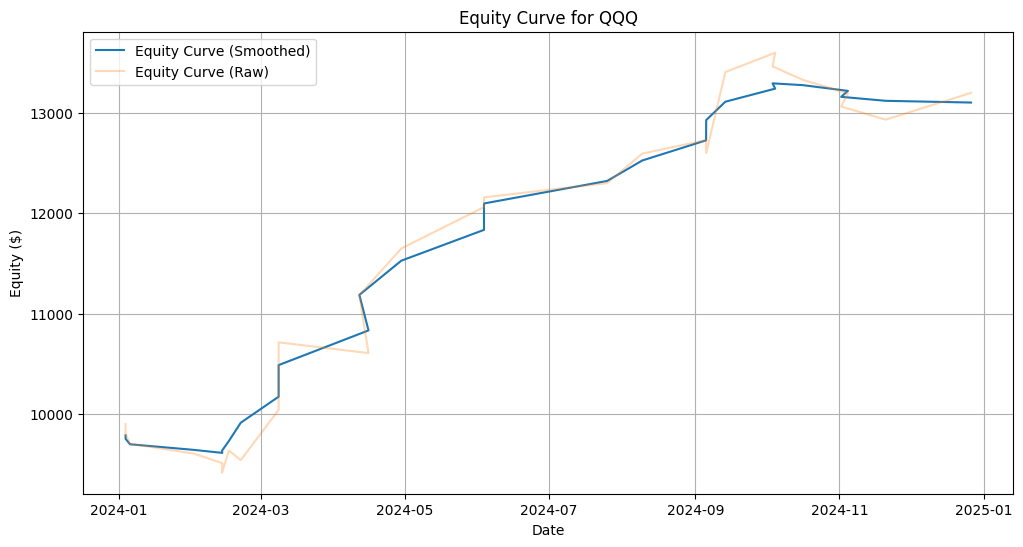

                   EntryDate                  ExitDate       Entry        Stop      Target        Exit         R Signal  PositionSize        Equity
0  2024-01-03 18:30:00+00:00 2024-01-03 20:30:00+00:00  400.179993  398.079987  400.440002  398.079987 -1.000000     RB     47.618909   9900.000000
1  2024-01-03 19:30:00+00:00 2024-01-03 20:30:00+00:00  398.779999  398.470001  400.440002  398.470001 -1.000000    RBM    319.357354   9801.000000
2  2024-01-05 14:30:00+00:00 2024-01-05 17:30:00+00:00  398.589996  396.160004  406.690002  396.160004 -1.000000     BV     40.333455   9702.990000
3  2024-02-01 14:30:00+00:00 2024-02-01 15:30:00+00:00  420.309998  417.839996  430.239990  417.839996 -1.000000     BV     39.283341   9605.960100
4  2024-02-13 14:30:00+00:00 2024-02-13 19:30:00+00:00  430.065002  426.279999  434.980011  426.279999 -1.000000     BV     25.378998   9509.900499
5  2024-02-13 15:30:00+00:00 2024-02-13 16:30:00+00:00  430.320007  429.670013  434.989990  429.670013 -1.000000

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

TICKER = "QQQ"
START = "2024-01-01"
END = "2024-12-31"

WICK_FACTOR = 2.0
VOLUME_MULTIPLIER = 1.5
VOLUME_WINDOW = 20
TREND_LOOKBACK = 50
LOOKBACK_SR = 20
MIN_BODY_FRAC = 0.001
RR_RATIO = 10.0
SUPPORT_PROX = 0.01
INITIAL_CAPITAL = 10000
RISK_PER_TRADE = 0.01

def load_data_yf(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval="1h", auto_adjust=False)
    if df is None or df.empty:
        raise ValueError("No data downloaded. Check ticker/dates or network.")
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    df = df.reset_index()
    df.columns = [str(c).strip().title() for c in df.columns]
    if "Adj Close" in df.columns and "Close" not in df.columns:
        df.rename(columns={"Adj Close": "Close"}, inplace=True)
    if "Date" not in df.columns and "Datetime" in df.columns:
        df.rename(columns={"Datetime": "Date"}, inplace=True)
    required = ["Date", "Open", "High", "Low", "Close", "Volume"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    df = df.loc[:, required].copy()
    df = df.sort_values("Date").reset_index(drop=True)
    return df

def identify_trend(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["EMA50"] = df["Close"].ewm(span=TREND_LOOKBACK, adjust=False).mean()
    df["Trend"] = np.where(df["Close"] < df["EMA50"], "Down", "Up")
    return df

def identify_support_resistance(df: pd.DataFrame, lookback: int = LOOKBACK_SR) -> pd.DataFrame:
    df = df.copy()
    is_swing_low = (df["Low"].shift(1) > df["Low"]) & (df["Low"].shift(-1) > df["Low"])
    is_swing_high = (df["High"].shift(1) < df["High"]) & (df["High"].shift(-1) < df["High"])
    df["SwingLow"] = np.where(is_swing_low, df["Low"], np.nan)
    df["SwingHigh"] = np.where(is_swing_high, df["High"], np.nan)
    df["Support"] = df["SwingLow"].rolling(window=lookback, min_periods=1).min()
    return df

def detect_bullish_rb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    body = (df["Close"] - df["Open"]).abs()
    is_bull = df["Close"] > df["Open"]
    lower_wick = df["Open"] - df["Low"]
    upper_wick = df["High"] - df["Close"]
    cond = (
        is_bull &
        (lower_wick > body * WICK_FACTOR) &
        (upper_wick < body) &
        (body > df["Close"] * MIN_BODY_FRAC)
    )
    df["Bullish_RB"] = cond.astype(int)
    return df

def detect_bv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    avg_vol = df["Volume"].rolling(window=VOLUME_WINDOW, min_periods=1).mean()
    cond = (df["Close"] > df["Open"]) & (df["Volume"] > avg_vol * VOLUME_MULTIPLIER)
    df["BV"] = cond.astype(int)
    return df

def detect_rsrb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["RSRB"] = 0
    last_rb_low = np.nan
    for i in range(len(df)):
        if df.at[i, "Bullish_RB"] == 1:
            if not np.isnan(last_rb_low):
                if abs(df.at[i, "Low"] - last_rb_low) / max(df.at[i, "Close"], 1e-12) < 0.01:
                    df.at[i, "RSRB"] = 1
            last_rb_low = df.at[i, "Low"]
    return df

def detect_rbm(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["RBM"] = 0
    for i in range(1, len(df)):
        if df.at[i-1, "Bullish_RB"] == 1 and df.at[i, "Close"] > df.at[i-1, "Low"]:
            df.at[i, "RBM"] = 1
    return df

def find_fta(df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    df = df.copy()
    swing = df["SwingHigh"].ffill()
    rev = swing[::-1]
    fut_max = rev.rolling(window=window, min_periods=1).max()[::-1]
    df["FTA"] = fut_max.shift(-1)
    return df

def build_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = identify_trend(df)
    df = identify_support_resistance(df)
    df = detect_bullish_rb(df)
    df = detect_bv(df)
    df = detect_rsrb(df)
    df = detect_rbm(df)
    df = find_fta(df)
    return df

def simulate_trades(df: pd.DataFrame) -> pd.DataFrame:
    records = []
    equity_curve = []
    capital = INITIAL_CAPITAL
    for i in range(len(df)):
        row = df.iloc[i]
        support = row.get("Support")
        if (
            row.get("Trend", "") == "Down"
            and pd.notna(support)
            and row["Low"] <= support * (1 + SUPPORT_PROX)
            and ((int(row.get("BV", 0)) == 1) or (int(row.get("Bullish_RB", 0)) == 1) or (int(row.get("RSRB", 0)) == 1) or (int(row.get("RBM", 0)) == 1))
        ):
            entry = float(row["Close"])
            stop = float(row["Low"])
            risk_amount = capital * RISK_PER_TRADE
            position_size = risk_amount / max(entry - stop, 1e-8)
            target = entry + RR_RATIO * (entry - stop)
            fta = row.get("FTA")
            if pd.notna(fta):
                try:
                    target = min(target, float(fta))
                except Exception:
                    pass
            outcome = None
            exit_price = None
            exit_date = None
            for j in range(i + 1, len(df)):
                h = float(df.at[j, "High"])
                l = float(df.at[j, "Low"])
                d = df.at[j, "Date"]
                if l <= stop:
                    outcome = -1.0
                    exit_price = stop
                    exit_date = d
                    break
                if h >= target:
                    outcome = (target - entry) / (entry - stop)
                    exit_price = target
                    exit_date = d
                    break
            if outcome is None:
                exit_price = float(df.iloc[-1]["Close"])
                exit_date = df.iloc[-1]["Date"]
                outcome = (exit_price - entry) / (entry - stop)
            capital += outcome * risk_amount
            equity_curve.append((exit_date, capital))
            signal_name = "BV" if int(row.get("BV", 0)) == 1 else ("RB" if int(row.get("Bullish_RB", 0)) == 1 else ("RSRB" if int(row.get("RSRB", 0)) == 1 else "RBM"))
            records.append({
                "EntryDate": row["Date"],
                "ExitDate": exit_date,
                "Entry": entry,
                "Stop": stop,
                "Target": target,
                "Exit": exit_price,
                "R": outcome,
                "Signal": signal_name,
                "PositionSize": position_size,
                "Equity": capital
            })
    trades_df = pd.DataFrame(records)
    equity_df = pd.DataFrame(equity_curve, columns=["Date", "Equity"]).set_index("Date")
    smooth_equity = gaussian_filter1d(equity_df["Equity"].values, sigma=2)
    plt.figure(figsize=(12,6))
    plt.plot(equity_df.index, smooth_equity, label="Equity Curve (Smoothed)")
    plt.plot(equity_df.index, equity_df["Equity"], alpha=0.3, label="Equity Curve (Raw)")
    plt.title(f"Equity Curve for {TICKER}")
    plt.xlabel("Date")
    plt.ylabel("Equity ($)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return trades_df

if __name__ == "__main__":
    df = load_data_yf(TICKER, START, END)
    df = build_signals(df)
    trades = simulate_trades(df)
    print(trades)
